In [1]:
import numpy as np
import numba as nb

In [43]:
class LorenzEquations:
    def __init__(self, 
            state: np.ndarray = None,
            sigma: float = 10.0, 
            rho: float = 28, 
            beta: float = 8 / 3, 
            dt: float = 0.01
        ) -> None:
        
        if state is None:
            state = np.random.rand(3)

        self.state = state
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt

    def equations(self, state: np.ndarray):
        x, y, z = state
        sigma, rho, beta = self.sigma, self.rho, self.beta
        return np.array([
            sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z
        ])

    def update_euler1(self):
        self.state = self.state + self.equations(self.state) * self.dt

    def update_runge_kutta2(self):
        k1 = self.equations(self.state)
        k2 = self.equations(self.state + k1 * self.dt)
        self.state = self.state + (k1 + k2) * self.dt / 2

In [30]:
from tqdm.notebook import tqdm

le = LorenzEquations(state=np.array([1.0, 1.0, 1.0]))

states = []

for _ in tqdm(range(10000)):
    le.update_euler1()
    states.append(le.state)

states = np.array(states)

  0%|          | 0/10000 [00:00<?, ?it/s]

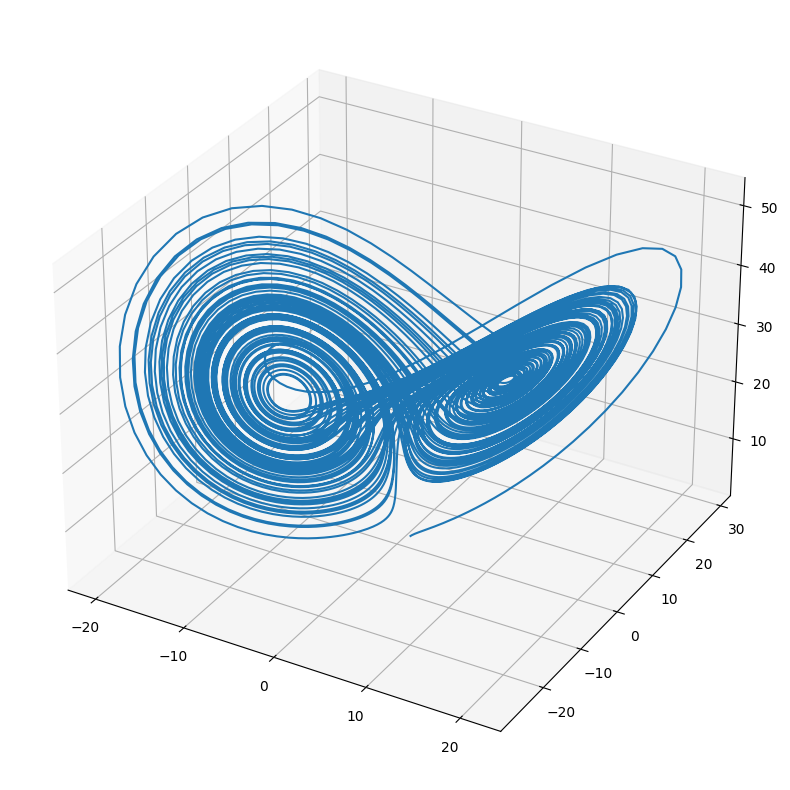

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.show()

In [32]:
import matplotlib.animation as ma
plt.rcParams['animation.ffmpeg_path'] = "D:/Programs/ffmpeg/bin/ffmpeg.exe"

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})

def plot_frame(i):
    ax.clear()
    ax.plot(states[:i, 0], states[:i, 1], states[:i, 2])
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)
    return ax

anim = ma.FuncAnimation(fig, plot_frame, frames=tqdm(range(0, len(states), 10)), interval=100)
anim.save('lorenz.mp4', writer='ffmpeg')
plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
class LorenzEquations:
    def __init__(self, 
            state: np.ndarray = None,
            sigma: float = 10.0, 
            rho: float = 28, 
            beta: float = 8 / 3, 
            dt: float = 0.01
        ) -> None:
        
        if state is None:
            state = np.random.rand(3)

        self.state = state
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt

    def equations(self, state: np.ndarray):
        sigma, rho, beta = self.sigma, self.rho, self.beta
        return self.equations_nb(state, sigma, rho, beta)

    @staticmethod
    @nb.njit
    def equations_nb(state: np.ndarray, sigma: float, rho: float, beta: float):
        x, y, z = state
        return np.array([
            sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z
        ])

    def update_euler1(self):
        self.state = self.state + self.equations(self.state) * self.dt

    def update_runge_kutta2(self):
        k1 = self.equations(self.state)
        k2 = self.equations(self.state + k1 * self.dt)
        self.state = self.state + (k1 + k2) * self.dt / 2

In [52]:
le = LorenzEquations(state=np.array([1.0, 1.0, 1.0]))

In [45]:
%%timeit
le.update_euler1()

3.75 µs ± 35.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [53]:
%%timeit
le.update_euler1()

2.73 µs ± 16.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [72]:
lastStates = []

for i in tqdm(range(4000)):
    np.random.seed(i)
    le = LorenzEquations()
    for _ in range(10000):
        le.update_euler1()
    lastStates.append(le.state)

lastStates = np.array(lastStates)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [76]:
lastStates = []

le = LorenzEquations()
for _ in range(100000):
    le.update_euler1()
    lastStates.append(le.state)

lastStates = np.array(lastStates[-10000:])

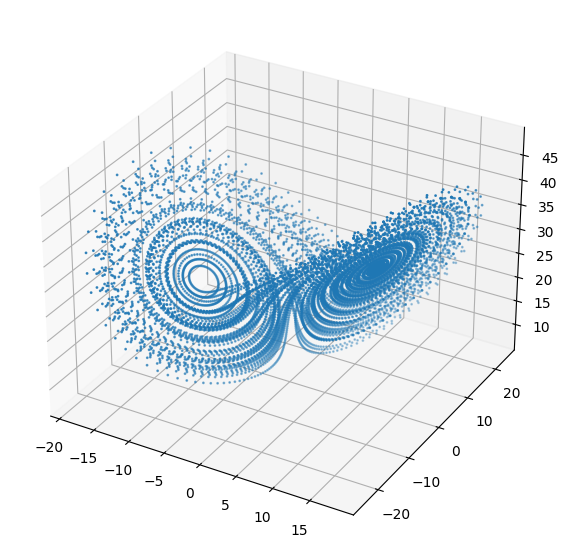

In [77]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': '3d'})
ax.scatter(lastStates[:, 0], lastStates[:, 1], lastStates[:, 2], s=1)
plt.show()

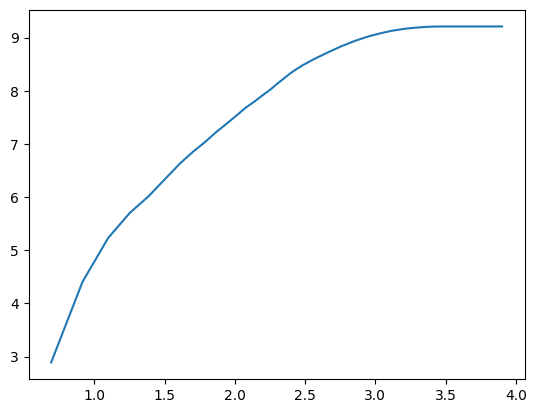

In [78]:
core = lastStates.mean(axis=0)

steps = np.arange(0, 50, 0.5)
delta = lastStates - core
distances = np.sqrt((delta ** 2).sum(axis=1))
Ncore = []

for step in steps:
    Ncore.append((distances < step).sum())

Ncore = np.array(Ncore)
steps = steps[Ncore > 0]
Ncore = Ncore[Ncore > 0]

plt.plot(np.log(steps), np.log(Ncore))

In [79]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
logSteps, logNcore = np.log(steps), np.log(Ncore)
logStepsForFit = logSteps[(1.5 < logSteps) & (logSteps < 2.5)].reshape(-1, 1)
logNcoreForFit = logNcore[(1.5 < logSteps) & (logSteps < 2.5)].reshape(-1, 1)

lr.fit(logStepsForFit, logNcoreForFit)
lr.coef_

array([[2.15466512]])